# 03. Building Makemore from scratch (Part2: MLP)

* Makemore makes more of the things you give it.
* makemore takes one text file as input, where each line is assumed to be one training thing, and generates more things like it. Under the hood, it is an autoregressive character-level language model, with a wide choice of models from bigrams all the way to a Transformer (exactly as seen in GPT). For example, we can feed it a database of names, and makemore will generate cool baby name ideas that all sound name-like, but are not already existing names. Or if we feed it a database of company names then we can generate new ideas for a name of a company. Or we can just feed it valid scrabble words and generate english-like babble.
* it is basically a bigram character-level language model

**Resources:**

* makemore github repo: https://github.com/karpathy/makemore/tree/master

* tutorial lecture 3 (makemore part 2) code: https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part2_mlp.ipynb

* MLP model based on 2003 paper: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

* makemore pre defined code: https://github.com/karpathy/makemore/blob/master/makemore.py

* link to youtube lecture: https://www.youtube.com/watch?v=TCH_1BHY58I&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=3

* whole lecture series code: https://github.com/karpathy/nn-zero-to-hero



## 0. Research paper walkthrough

* they utilize a word level language model but we'll stick to character level with the same modelling approach
* they propose to take every one of 17,000 words and they will associate each word with a 30 dimensional feature vector, so every word is now embedded now into a 30-D space -> that's quite crowded
* initially these words are initialized randomly, but we are going to tune these embeddings of these words using backpropogation
* during the course of training of this neural network, these points or vectors are going to basically move around in the space e.g words that are synonyms might end up in a similar space, and conversely antonyms would end up in different places of the space.
* they are using a multi-neural network to predict the next word from the previous words, and to train the neural network they are maximising the log likelihood of the training data just like we did in part 1 -> modelling approach itself is identical.
* check dog example on page 1140 of the paper -> network can learn that a few words like 'a' and 'the' can be used interchangeably, so maybe it took the embedding for both words and it put them nearby in the space, so we can transfer knowledge through that embedding and generalize in that way.
  * Similarly, the network might know that 'dog' and 'cat' are both animals, so even if the network hasn't seen the exact phrase before, one can through the embedding space transfer knowledge and you can generalize to novel scenarios.
* in an example on page 1142, there are 3 previous words from 17000 words vocabulary dictionary being used to predict the next word, so the each of the 3 previous words are the index of the incoming word and thus can range from 0 to 16999.
  * there is also a lookup table in the paper called `C`, which is a matrix of [17,000, 30], every index is plucking out a row of this embedding matrix so that each index is coverted to the 30-D vector that corresponds to the embedding vector for that word.
  * we index the same matrix `C` over and over for each one of these words.
* the size of the hidden layer in this neural net is a hyperparameter -> can be as large as you u like, or as small as you look
  * we will go over different sizes of this hidden layer and evaluate how they will work.
  * for example, if they were a 100 neurons in the hidden layer, all of them would be fully connected to the 90 numbers that make up these 3 words -> there is a fully connected layer, then there is `tanh()` linearity and then there is an output layer, and because of our 17,000 words that could come next, this layer has 17,000 neurons and all of them are fully connected to the neurons in the hidden layer -> a lot of parameters as there are a lot of words
* during the training we have the label, we have the identity of the next word in the sequence, that word or its index is used to pluck out the probability of that word, and then we are maximising the probability of that word w.r.t the parameters of this neural net;
  * so the parameters are the weights and biases of this output layer, the weights and biases of the hidden layer, and the embedding lookup table `C`, and all that is optimized using backpropogation
  * ignore the dashed arrows, they represent a variation of the neural net which won't be explored in this lecture.


## 1. Building dataset

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
!wget https://github.com/karpathy/makemore/raw/master/names.txt

--2024-08-21 16:31:44--  https://github.com/karpathy/makemore/raw/master/names.txt
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/karpathy/makemore/master/names.txt [following]
--2024-08-21 16:31:44--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2024-08-21 16:31:44 (6.11 MB/s) - ‘names.txt’ saved [228145/228145]



In [4]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


* block_size = context length: how many characters do we take to predict the next one? here we take 3 previous charcters to predict the 4th one.
* x are the input in the neural net, and y are the labels
* the 3 letter examples that we can generate from the word are then listed
* initially started with a padded context of 0 tokens
  * then iterate over all the characters and get the character in the sequence and build out the array y of this current character (`Y.append(ix)`), and the array X which stores the current context (`X.append(context)`), then after printing everything the context is cropped and the new character is entered into the sequence, so this is like a rolling window of context


In [7]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:

  print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [8]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [9]:
# X (individual examples), Y (labels)

## 2. Building the neural net to take in the X and predict the Y

### 2.1 Implementing the embedding lookup table `C`

* we have 27 possible characters and we'll embed them into a lower dimensional space
* in the paper they embed 17,000 words into a 30-D space so in our case we will cramp the 27 characters in something as small as we can do, starting with a 2-D space.
  * each 27 character will have 2D embedding hence 27 rows and 2 columns
  * before we embed all the integers inside the input X using this lookup table, we will first try to embed a single integer
  * `F.one_hot(torch.tensor(5), num_classes=27) @ C` won't work cuz PyTorch can't multiply an int with a float -> this output is identical to `C[5]` because of the way matrix multiplication here works: we have the one-hot vector multiplying columns of C, because of all the zeros we end up masking out everything in C except the 5th row which is plucked out arriving at the same result.
  * this tells us that we can interpret the embedding of the first integer, we can either think of the integer indexing in the lookup table `C` but equivalently it can also be thought for the little piece to be the first layer of the neural net
    * this first layer has neurons which have no non-linearity, and the weight matrix is C, we're encoding the integers into one-hot and then feeding them into the neural net -> this first layer of the integer basically embeds them
    * we go with indexing integers as it's easier instead of one-hot encoding.

In [10]:
# F.one_hot(torch.tensor(5), num_classes=27).float() @ C # embedding the integer 5 with 26-D space of zeros with the 27th one turned on

In [11]:
C = torch.randn(( 27, 2)) # embedding lookup table -> 27 rows, 2 columns as each one character will have a 2D embedding

In [12]:
C[5]

tensor([-0.0148,  0.8732])

In [13]:
emb = C[X] # indexing with multi-dimensional integers
emb.shape

torch.Size([32, 3, 2])

In [14]:
X[13, 2] # example index 13 in the 2nd dimension -> integer 1 is at that location

tensor(1)

In [15]:
emb[13, 2] # same as `C[1]`

tensor([ 0.8154, -0.5167])

### 2.2 Constructing the hidden layer + internals of `torch.Tensor`: storage and views

* number of inputs to the hidden layer will be 3*2 = 6, as we have 3 2D embeddings
* the embeddings are stacked up into the dimension of the input tensor so `[32, 3, 2]` won't matrix mutltiply with `[6, 100]` due to different shapes so we need to concantenate these inputs together using `torch.cat()`
* `torch.unbind()` removes a tensor dimension and returns a tuple of all slices along a given dimension, already without it.
* `(variable).view` helps you view your array in diff shapes as long as the inner dimensions multiple to give the correct total number of elements in the matrix or array, no memory is being changed, copied, removedo or created when we call it as the `storage` remains identical, some of the internal attributes of this view of this tensor are being manipulated and changed like `storage offset`, `strides`, and `shapes` so that is 1D space of bytes can be seen in n-dimensional ways
  * this operation is really efficient as there is in each tensor something called the underlying `storage` -> the storage is always as a 1D vector
  * `torch.cat()` is less efficient as a whole new tensor is created which takes up more memory
  * `h.shape` is **[32, 100]** which is basically the hidden layer of activations for every one of our 32 examples
  * addition between weights and biases will broadcast them:
  ```
  32, 100 # shape of weights `h`
    , 100 # broadcasting will align on right
  ```
    * a fake dimension is created to get [1, 100] row vector and then it will copy vertically for every one of these rows and do an element wise addition, so in this case the correct thing is being done since the same character bias will be added to the rows of the matrix.

In [16]:
W1 = torch.randn((6, 100)) # hidden layer (number of inputs, number of neurons (variable upto us))
b1 = torch.randn(100) # bias initalized randomly

In [17]:
emb[:, 0, :] # first character in the sequence

tensor([[ 1.1833,  1.1516],
        [ 1.1833,  1.1516],
        [ 1.1833,  1.1516],
        [-0.0148,  0.8732],
        [-0.5886,  0.2612],
        [ 1.1833,  1.1516],
        [ 1.1833,  1.1516],
        [ 1.1833,  1.1516],
        [ 0.8730,  0.5307],
        [ 1.1010,  1.9476],
        [-1.2337, -1.1843],
        [-2.6066,  2.1030],
        [ 1.1833,  1.1516],
        [ 1.1833,  1.1516],
        [ 1.1833,  1.1516],
        [ 0.8154, -0.5167],
        [ 1.1833,  1.1516],
        [ 1.1833,  1.1516],
        [ 1.1833,  1.1516],
        [-1.2337, -1.1843],
        [ 0.9974, -0.7798],
        [ 0.8154, -0.5167],
        [-0.2948,  0.3322],
        [-0.0148,  0.8732],
        [ 1.1010,  1.9476],
        [ 1.1833,  1.1516],
        [ 1.1833,  1.1516],
        [ 1.1833,  1.1516],
        [ 0.9974, -0.7798],
        [ 0.8730,  0.5307],
        [ 0.2928,  0.4604],
        [ 0.9700, -2.3085]])

In [18]:
# concatenating
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape

torch.Size([32, 6])

In [19]:
# same result as above, it does not matter if we have block size 3 or 5 or 10
torch.cat(torch.unbind(emb, dim=1), dim=1).shape

torch.Size([32, 6])

In [20]:
emb.view(32, 6) # everything in the row gets stacked up

tensor([[ 1.1833,  1.1516,  1.1833,  1.1516,  1.1833,  1.1516],
        [ 1.1833,  1.1516,  1.1833,  1.1516, -0.0148,  0.8732],
        [ 1.1833,  1.1516, -0.0148,  0.8732, -0.5886,  0.2612],
        [-0.0148,  0.8732, -0.5886,  0.2612, -0.5886,  0.2612],
        [-0.5886,  0.2612, -0.5886,  0.2612,  0.8154, -0.5167],
        [ 1.1833,  1.1516,  1.1833,  1.1516,  1.1833,  1.1516],
        [ 1.1833,  1.1516,  1.1833,  1.1516,  0.8730,  0.5307],
        [ 1.1833,  1.1516,  0.8730,  0.5307,  1.1010,  1.9476],
        [ 0.8730,  0.5307,  1.1010,  1.9476, -1.2337, -1.1843],
        [ 1.1010,  1.9476, -1.2337, -1.1843, -2.6066,  2.1030],
        [-1.2337, -1.1843, -2.6066,  2.1030, -1.2337, -1.1843],
        [-2.6066,  2.1030, -1.2337, -1.1843,  0.8154, -0.5167],
        [ 1.1833,  1.1516,  1.1833,  1.1516,  1.1833,  1.1516],
        [ 1.1833,  1.1516,  1.1833,  1.1516,  0.8154, -0.5167],
        [ 1.1833,  1.1516,  0.8154, -0.5167, -2.6066,  2.1030],
        [ 0.8154, -0.5167, -2.6066,  2.1

In [21]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # @ is matrix multiplication, we enter -1 as PyTorch will derive that the number of elements must be same

In [22]:
h, h.shape # numbers between 1 and -1 due to the `tanh`

(tensor([[-0.9999, -0.7006, -0.3811,  ...,  0.9015,  0.9969,  0.9142],
         [-0.9991, -0.3314,  0.4993,  ...,  0.9689,  0.9478,  0.3210],
         [-0.6243,  0.8203,  0.8417,  ...,  0.9832,  0.9394, -0.8403],
         ...,
         [-0.9236,  0.5341,  0.9994,  ...,  0.9427,  0.9901,  0.7369],
         [-0.9919,  1.0000,  0.9167,  ..., -0.9357, -0.9998, -1.0000],
         [ 0.9936,  0.9994,  0.9400,  ..., -0.0245,  0.7342, -0.7900]]),
 torch.Size([32, 100]))

### 2.3 Implementing the output layer

* input now is 100 and the output number of neurons for us will be 27 since we have 27 possible characters so the biases will be 27 as well
* therfore, the logits which are the outputs of this neural net are going to be `h @ W2 + b2`

In [23]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [24]:
logits = h @ W2 + b2

In [25]:
logits.shape

torch.Size([32, 27])

### 2.4 Implementing the negative log likelihood loss

* we created `Y` when we created our dataset which is the last piece in our broken down examples layer in chapter 1 of this notebook, which is the identity of the next character in the sequence which we would like to now predict
* like in the previous video we will index into the row's of prob, and in each row we would like to pluck out the probability assigned to the correct character as given in `Y`

In [26]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims = True)
prob.shape

torch.Size([32, 27])

In [27]:
prob[0].sum() # every row of probs sums to 1 so it is normalized

tensor(1.)

In [28]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [29]:
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [30]:
prob[torch.arange(32), Y] # gives the current probabilities as assigned by this neural network through these weights to the correct character in the sequence

tensor([2.5122e-07, 5.5625e-13, 5.7881e-13, 8.3193e-08, 7.7748e-09, 9.8324e-13,
        4.0263e-06, 1.2964e-10, 5.2884e-05, 1.1374e-04, 9.7216e-11, 8.4758e-12,
        6.2966e-07, 9.2609e-03, 1.9689e-06, 9.9313e-01, 2.3958e-11, 3.2605e-10,
        3.4237e-13, 3.5162e-03, 2.5809e-03, 6.9287e-09, 1.0646e-11, 1.7234e-02,
        8.5318e-01, 6.6030e-09, 7.6711e-08, 7.1354e-07, 5.4950e-04, 4.5512e-07,
        3.6737e-09, 7.6859e-12])

In [31]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(16.2614)

### 2.5 Summary of network uptil now

In [32]:
X.shape, Y.shape # dataset

(torch.Size([32, 3]), torch.Size([32]))

In [33]:
# current parameters
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [34]:
sum(p.nelement() for p in parameters) # number of parameters in total


3481

In [35]:
# current forward pass
emb = C[X] # [32, 3, 2]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # [32, 100]
logits = h @ W2 + b2 # [32, 27]
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.7697)

### 2.6 Implementing `F.cross_entropy`

* in practice we don't use our implementation of loss much, we use `F.cross_entropy` because:
  1. PyTorch will not create this intermediate tensors, since all these tensors are new in memory, and all this is fairly inefficent to run like this. PyTorch will cluster up these operations and often created fused kernels which very efficiently evaluate these expressions that are sort of clustered mathematical expressions
  2. the backward pass can be made much more efficient not just because it's a fused kernel, but also analytically and mathematically it's often a very much simple backward pass to implement. We saw this in micrograd which was very complicated to calculate. The expressions can take a much simpler form with `F.cross_entropy()` mathematically.
  3. `F.cross_entropy()` can under the hood be much more numerically well behaved: a very negative number brings a small prob but a very positive number gives u an `inf` prob as we ran out of dynamic range on this floating point number so we can't pass very large logits with our own loss method, it overflows. We can arbitrarly shift the values too by adding or subtracting from the logits.
    * What PyTorch does with `F.cross_entropy()` is that it internally calculates the max value that occurs in the logits and it subtracts that value from all the logits, so one of the logits (the max one) will become 0 and the rest will become some negative number and the result of this always is well behaved so even if the original logits don't output a great probability, the subtraction of the max value from the logits by PyTorch will make it work.
  * **so in essence by calling `F.cross_entropy()` the forward pass and backward pass will be much more efficient, and the things will be much more numerically well-behaved.**

In [36]:
F.cross_entropy(logits, Y)

tensor(17.7697)

In [37]:
emb = C[X] # [32, 3, 2]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # [32, 100]
logits = h @ W2 + b2 # [32, 27]
loss = F.cross_entropy(logits, Y)
loss

tensor(17.7697)

In [38]:
# manual loss (without `F.cross_entropy()`)
logits = torch.tensor([-5, -3, 0, 100])
counts = logits.exp()
prob = counts / counts.sum()
prob

tensor([0., 0., 0., nan])

In [39]:
# example of `F.cross_entropy()` implementation manually (check without subtraction and see)
logits = torch.tensor([-5, -3, 0, 100]) - 100
counts = logits.exp()
prob = counts / counts.sum()
prob

tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00])

### 2.7 Implementing the training loop and overfitting one batch

* initially we're overfitting only 32 examples so it's very easy to fit this neural net with 3481 parameters: named as overfitting one batch and getting a very low loss
  * loss is not equally 0 because '...' is supposed to predict the first character of a lot of words in the dataset -> all possible outcomes in the dataset for the exact same input so we're not able to completely overfit and make the loss exactly 0, in the cases where there is a unique input and a unique output -> in those cases we overfit and we get the correct result

In [40]:
for p in parameters:
  p.requires_grad = True

In [41]:
for _ in range(100):

  # forward pass
  emb = C[X] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y)
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  for p in parameters:
    p.data += -0.1 * p.grad
  #lr = lrs[i]
  # lr = 0.1 if i < 100000 else 0.01
  # for p in parameters:
  #   p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  # stepi.append(i)
  # lossi.append(loss.log10().item())

print(loss.item())

0.3367388844490051


### 2.8 Training the full dataset in mini batches

* each training step or epoch or iteration takes a very long time so we will repeat the iterations in a small batch
* the integers we want to optimize in a single iteration are in `ix` and then we want to index in `X` with `ix` to only grab those rows, so we'll be getting only 32 rows of X so the embedding remains the same: [32, 3, 2], indexed in `Y` as well
* as we're dealing with mini batches, the quality of our gradient is lower so the direction is not as reliable, it's not the actual gradient direction but the gradient direction is good enough even when it is estimating on only 32 examples
  * much better to have an approximate gradient and just make more steps than it is to evaluate the exact gradient and take fewer steps so that's why in practice it works quite well.




In [42]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:

  # print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [43]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [44]:
# reinitialising the weights
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [45]:
sum(p.nelement() for p in parameters) # number of parameters in total


3481

In [46]:
for p in parameters:
  p.requires_grad = True

In [47]:
torch.randint(0, X.shape[0], (32,))

tensor([175779, 120827, 189972,  95293, 198839, 214976,  19133,  25390, 190193,
        206110, 129669, 154219, 212748,  65616, 214520, 101876, 200631, 109027,
         92906,  34152, 104007,  41993, 188697, 165712, 173495, 110006,   3190,
        164402,  96173, 196113, 141739,  37430])

In [48]:
for _ in range(1000):

  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32,))

  # forward pass
  emb = C[X[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  for p in parameters:
    p.data += -0.1 * p.grad

print(loss.item())

2.685664415359497


In [49]:
# loss of entire training set right now

emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

tensor(2.6747, grad_fn=<NllLossBackward0>)

### 2.9 Finding a good learning rate

* how do we guess a good lr when we just have it as 0.1 randomly?
* while calculating `lre` and `lrs` we're trying to linearly step between the exponents of these learning rate -> so our lr increases exponentially starting from very low like 0.01 and going upto -1.
  * lr uptil 0.1 performs well then the loss gets really unstable with increasing lr
  * somewhere around -1 is the exponent of the learning rate working really well
* this is really not the best approach to take in production but it is roughly how it will take place:
  * you first find a decent lr using the approach we saw, we stick with that lr and train it for a while, and then in the end we do a lr decay where we decay the lr by say a factor of 10 and we do a few more steps and we get a trained network -> improved a lot on the bigram model


In [50]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:

  # print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [51]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [52]:
# reinitialising the weights
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [53]:
sum(p.nelement() for p in parameters) # number of parameters in total


3481

In [54]:
for p in parameters:
  p.requires_grad = True

In [55]:
# Tweaking the learning rate
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [56]:
lri = []
lossi = []

for i in range(10000):

  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32,))

  # forward pass
  emb = C[X[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y[ix])
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  # lr = lrs[i]
  lr = 0.1
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  # lri.append(lre[i])
  # stepi.append(i)
  # lossi.append(loss.log10().item())

# print(loss.item())

In [57]:
# Achieved a loss of 2.4251 after 3 iterations of the above cell

emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

tensor(2.4800, grad_fn=<NllLossBackward0>)

In [58]:
# plt.plot(lri, lossi);

### 2.10 Splitting the dataset into train/val/test splits

* model is not actually good:
  * the model is very small with 3400 parameters which can get very large if you keep adding neurons and parameters, and as the capacity of the neural net grows it grows more capable of overfitting your training set. That means the loss on the training set will become very low as low as 0, but all the model is doing is that it is memorizing your training set verbatim
  * if you take the model and try to sample from it, you will basically get the examples exactly as they are in the training set, you won't get any new data
  * in addition to that, if you try to evaluate the model on some witheld names or words, you acc see that the loss on those can be very high.

* data split into 80%, 10%, 10% respectively
  * 80% of the training set is used to optimize the parameters of the model just like before using gradient descent
  * 10% of the validation/dev split is used for development over all the hyperparameters of your model. Hyperparamters are for example the size of the hidden layer, the size of the embedding, the strength of the regularization -> can tweak them and see which works best
  * 10% of test split is used to evaluate the performance of the model in the end -> evaluating the loss on the test split very few times because every single time you evaluate your test loss and you learn something from it, you are also basically starting to also train on the test split so you are only allowed to test the loss on the test split very very few times otherwise you risk overfitting it as well as you experiment on your model

In [59]:
# build the dataset

def build_dataset(words):
  block_size = 3 # context length: how many characters do we take to predict the next one?
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# prints the individual examples made from those words
Xtr, Ytr = build_dataset(words[:n1]) # 25626 words for training split
Xdev, Ydev = build_dataset(words[n1:n2]) # n2 - n1 = 3203: validation split words
Xte, Yte = build_dataset(words[n2:]) # len(words) - n2 = 3204: test split words

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [60]:
len(words), n1, n2

(32033, 25626, 28829)

In [61]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [62]:
# Set the weights
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [63]:
# number of parameters in total
sum(p.nelement() for p in parameters)


3481

In [64]:
for p in parameters:
  p.requires_grad = True

In [65]:
# Tweaking the learning rate
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [66]:
lri = []
lossi = []

for i in range(30000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  # lr = lrs[i]
  lr = 0.1
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  # lri.append(lre[i])
  # stepi.append(i)
  # lossi.append(loss.log10().item())

print(loss.item())

2.4006364345550537


In [67]:
# Calculate training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3866, grad_fn=<NllLossBackward0>)

In [68]:
# Calculate dev loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3840, grad_fn=<NllLossBackward0>)

* Training and dev loss are about equal so we're not overfitting
* This model is not powerful enough to just be purely memorising the data and so far we're underfitting because the training loss and dev loss are roughly equal so that usually means that our network is very tiny
* we expect to make performance improvements by scaling up the size of neural net

## 3. Experiment 1: larger hidden layer

* There's a lot of thickness in the plot as the epochs increase because of the noise minibatches create
* it could be that batch size is so low that we have too much noise in the training, and we might want to increase so we have a correct gradient and are not thrashing too much, and we can actually optimize properly
* although we have made the hidden layer much bigger, it can be that the bottleneck of the network are these embeddings which are 2D, it can be that we are scrambing too many characters into just 2D and the neural net is not able to really use that space effectively.

In [113]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [114]:
# Increasing size of neural net
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g) # hidden layer sized increased to 300 from 100
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [115]:
# number of parameters in total
sum(p.nelement() for p in parameters)

10281

In [116]:
# Setting gradients = True
for p in parameters:
  p.requires_grad = True

In [88]:
# Tweaking the learning rate
# lre = torch.linspace(-3, 0, 1000)
# lrs = 10**lre

In [126]:
lri = []
lossi = []
stepi = []

for i in range(30000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  # lr = lrs[i]
  lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  # lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.item())

# print(loss.item())

In [127]:
# Calculate training loss: 2.2653 after running with lr = 0.1 once, 0.05 once, and 0.01 twice
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2653, grad_fn=<NllLossBackward0>)

In [128]:
# Calculate dev loss: 2.2687 after running with lr = 0.1 once, 0.05 once, and 0.01 twice
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2687, grad_fn=<NllLossBackward0>)

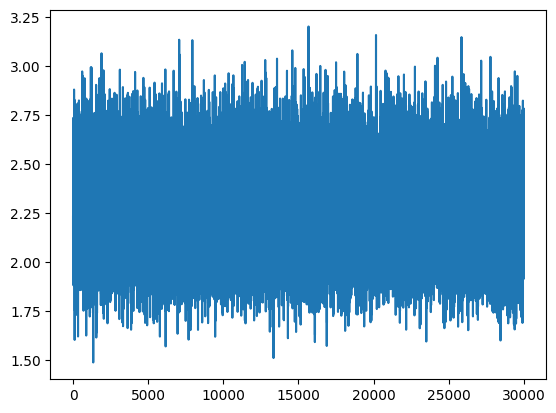

In [129]:
plt.plot(stepi, lossi);

### 3.1 Visualizing the character embeddings

* the embedding size currently is only 2 so we can visualize them with x and y coordinates as the 2 embedding locations for each of these characters
* the network has basically learnt to seperate out the characters and cluster them a little bit
* a little bit of structure exists after training and the assortment is not random hence the embeddings makes sense


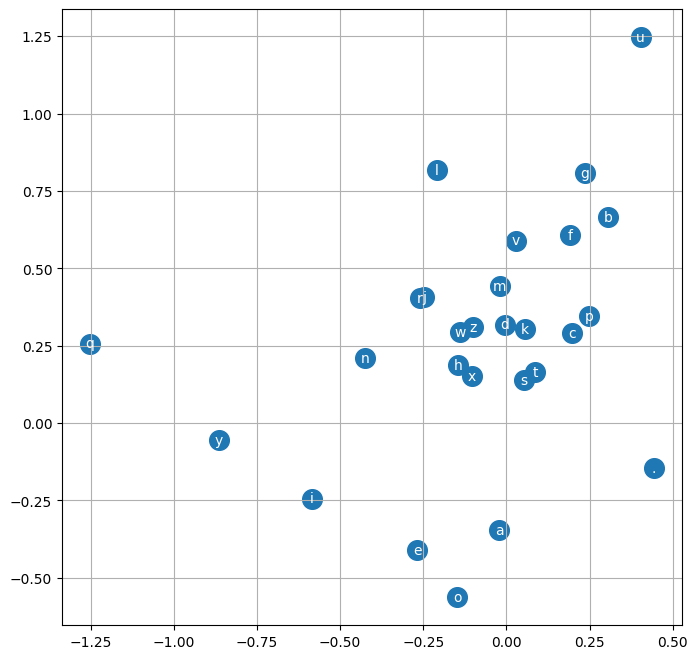

In [130]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

## 4. Experiment 2: Increasing embedding size (final model)

* since we're underfitting we'll increase the embedding size (hence, won't be able to visualize it directly)
* since increasing the hidden layer did not improve the loss very much, maybe increasing the embeddings will
* what we're changing:
  * 10D embedding space for each word
  * 3*10 = (30, 200) # 30 inputs into the hidden layer
  * reducing the hidden layer a little bit from 300 to 200
  * total number of elements a little bigger to 11,000 compared to 10,000 from before
* loss shapes in the plot like a hockey stick and the log squashes it in
  * loss finally shaping into what we want so we might finally be overfitting
* production from our haphazard experiment would differ by creating hyperparameters out of all of these settings, and we would draw a lot of experiments and see which one's are working well for you
  * all they hyperparameters that make your dev performance good, you take that model and evaluate the test set performance a single time and that's the number that is reported in the paper/finally.
  * Multiple ways to go from here:
    * we can continue tuning the optimization, we can continue playing with the size of our neural net, or we can increase the number of words (or characters in our case) that are being taken as an input, so instead of 3 characters we could take more characters as input and that could further improve the loss.


In [131]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [132]:
# Increasing the embedding size and reinitialzing weights
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g) # 10D embedding for each word
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g) # reduced hidden layer size
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [133]:
# Increased parameters from last experiment
sum(p.nelement() for p in parameters)

11897

In [134]:
# All parameters require gradient for tracking
for p in parameters:
  p.requires_grad = True

In [135]:
# Tweaking learning rate from before
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [136]:
# Initializing so that when we run multiple times, our loss isn't wiped out
lri = []
lossi = []
stepi = []

In [150]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  # lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  # lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

# print(loss.item())

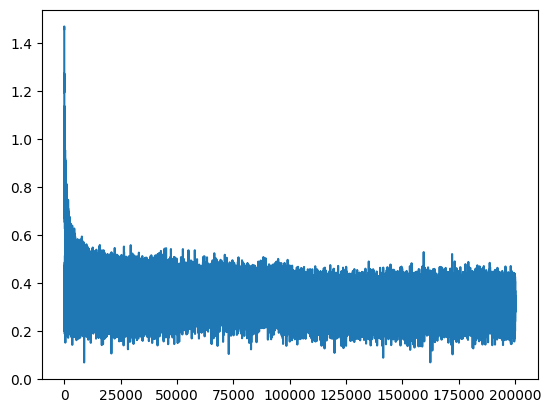

In [151]:
plt.plot(stepi, lossi);

In [152]:
# Calculate training loss: 2.0914 after running with the current code
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0914, grad_fn=<NllLossBackward0>)

In [153]:
# Calculate dev loss: 2.1398 after running with the current code
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1398, grad_fn=<NllLossBackward0>)

## 5. Sampling from the model

* at first we begin with all dots so that's the context
* until we generate the 0th character again, we're going to embed the current context using the embedding table `C`
* usually the first dimension was the size of the training set but here we're only working with a single example we're working so it's just dimension 1 for simplicity
* the embedding then gets projected into the hidden state, you get the logits and then calculate the probabilites using `f.softmax()` of logits -> exponentials the logits and sums them to one
* similar to cross entropy it is careful that there's no overflows
* once we have the probabilites we sample from them using `torch.multinomial` to get our next index and then we shift the context window to append the index and record it and then we can just decode all the integers to strings and then print them out
* these are some example samples and you can see that the model works much better.
* the words here are much wordlike or namelike

In [154]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

montammyah.
see.
medhayla.
rethan.
endraeg.
adelyn.
eliah.
milopi.
eden.
van.
nar.
kayzion.
kamin.
shebergiaghiel.
kin.
renleigh.
ter.
fius.
kynder.
yah.


## Summary..where to go from here?



* tutorial guy got a min dev loss of 2.17 after 100000 iterations
* few things can be tweaked:
  1. number of neurons in the hidden layer of this model
  2. dimensionality of the lookup table can be changed
  3. we can change the number of characters that are feeding in as an input as a context in the model
  4. we can change the details of optimization:
    * how long are we running
    * what learning rate are we using
    * how does the lr change over time? how does it decay?
  5. you can change the batch size? you might actually be able to achieve a better convergence speed in terms of how many seconds it takes to train the model and get the result in terms of your loss
  6. read the paper and try to understand it; implement the things suggested in the paper to get the best possible loss result
  